# CNN - Mask man Classification

## 데이터셋

In [2]:
import zipfile

content_zip = zipfile.ZipFile("./datas/archive.zip")
content_zip.extractall('./datas')

content_zip.close()

## 파일 정리

In [6]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

path = './datas/Face Mask Dataset/'
dataset = {'image_path' : [], 'mask_status' : [], 'where' : []}

print(os.listdir(path))
print(os.listdir(path + '/' + 'Train'))
print(glob.glob(path + 'Train' + '/' + 'WithMask' + '/' + '4.png'))

['Test', 'Train', 'Validation']
['WithoutMask', 'WithMask']
['./datas/Face Mask Dataset/Train/WithMask/4.png']


In [9]:
path = './datas/Face Mask Dataset/'
dataset = {'image_path' : [], 'mask_status' : [], 'where' : []}

for where in os.listdir(path) :
    for status in os.listdir(path + '/' + where) :
        for image in glob.glob(path + where + '/' + status + '/' + '*.png') :
            dataset['image_path'].append(image)
            dataset['mask_status'].append(status)
            dataset['where'].append(where)

dataset = pd.DataFrame(dataset)
dataset.head()

,image_path,mask_status,where
0,./datas/Face Mask Dataset/Test/WithoutMask/273...,WithoutMask,Test
1,./datas/Face Mask Dataset/Test/WithoutMask/434...,WithoutMask,Test
2,./datas/Face Mask Dataset/Test/WithoutMask/442...,WithoutMask,Test
3,./datas/Face Mask Dataset/Test/WithoutMask/205...,WithoutMask,Test
4,./datas/Face Mask Dataset/Test/WithoutMask/336...,WithoutMask,Test


## class 개수 비교

WithMask :  5909
WithoutMask :  5883


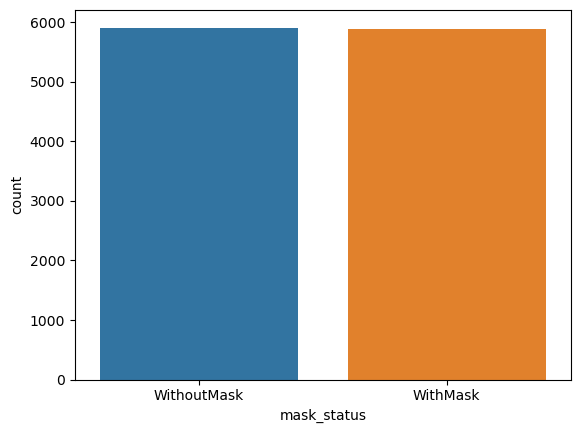

In [13]:
print("WithMask : ", dataset.value_counts('mask_status')[0])
print("WithoutMask : ", dataset.value_counts('mask_status')[1])

sns.countplot(x=dataset['mask_status'], hue=dataset['mask_status']);

## 랜덤하게 데이터 시각화

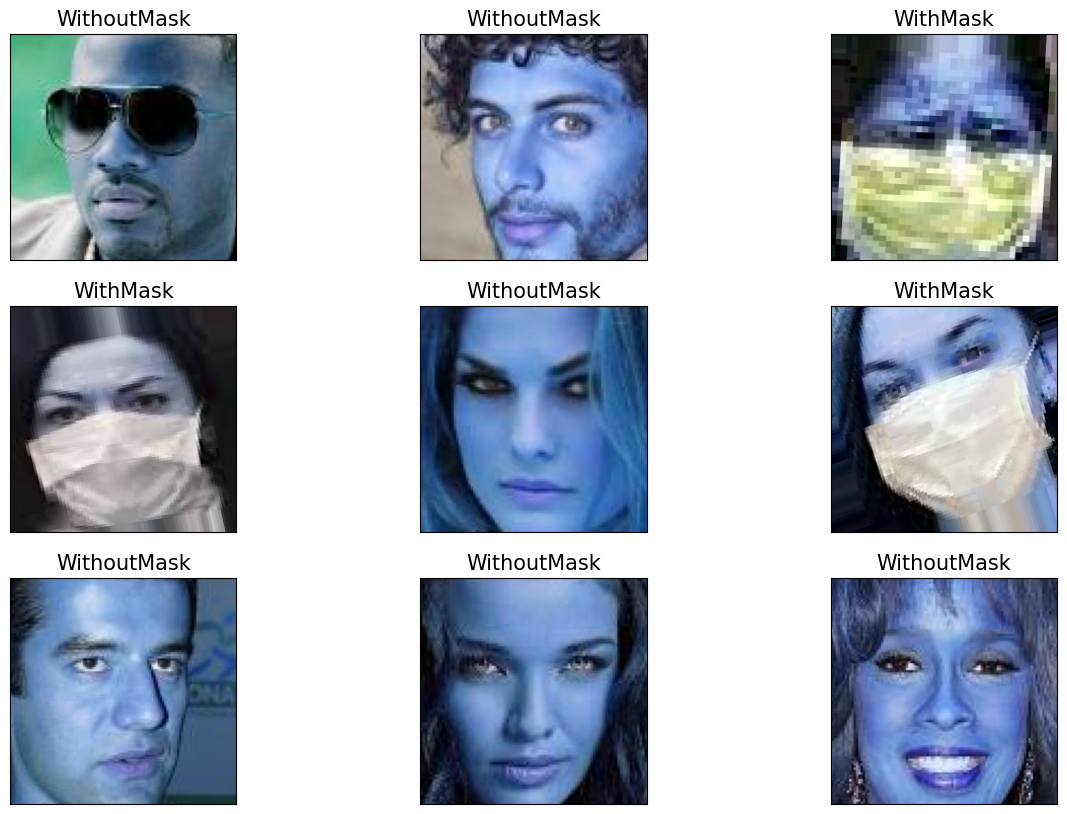

In [15]:
import cv2

plt.figure(figsize=(15, 10))
for i in range(9) :
    random = np.random.randint(1, len(dataset))
    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.imread(dataset.loc[random, "image_path"]))
    plt.title(dataset.loc[random, "mask_status"], size=15)
    plt.xticks([])
    plt.yticks([])
plt.show()

## Train, Test, Valid 데이터프레임 구분

In [22]:
train_df = dataset[dataset["where"] == "Train"].reset_index().drop("index", axis=1)
test_df = dataset[dataset["where"] == "Test"]
valid_df = dataset[dataset["where"] == "Validation"]

train_df.head()

,image_path,mask_status,where
0,./datas/Face Mask Dataset/Train/WithoutMask/39...,WithoutMask,Train
1,./datas/Face Mask Dataset/Train/WithoutMask/34...,WithoutMask,Train
2,./datas/Face Mask Dataset/Train/WithoutMask/18...,WithoutMask,Train
3,./datas/Face Mask Dataset/Train/WithoutMask/49...,WithoutMask,Train
4,./datas/Face Mask Dataset/Train/WithoutMask/18...,WithoutMask,Train


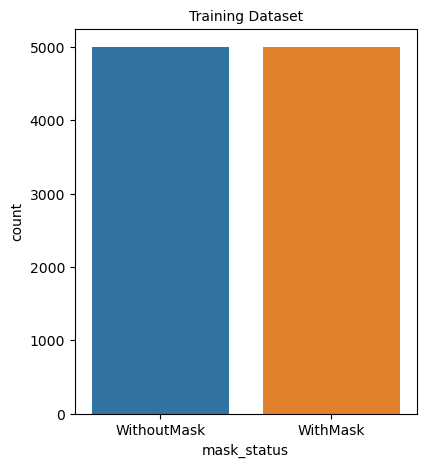

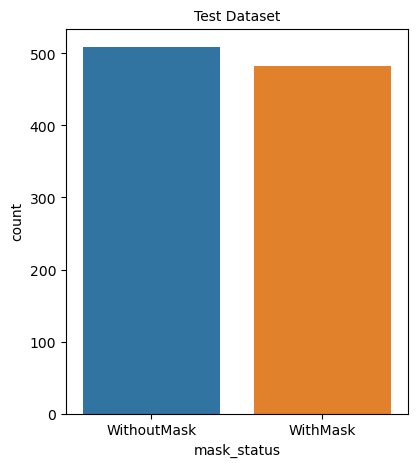

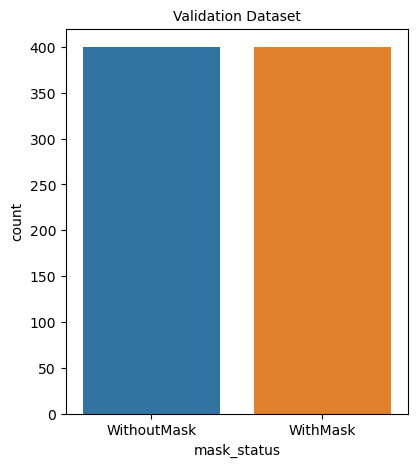

In [20]:
## 각 train, test, valid data 분포 확인
# Train countplot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x=train_df["mask_status"], hue=train_df["mask_status"])
plt.title("Training Dataset", size=10)

# Test countplot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x=test_df["mask_status"], hue=test_df["mask_status"])
plt.title("Test Dataset", size=10)

# Valid countplot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x=valid_df["mask_status"], hue=valid_df["mask_status"])
plt.title("Validation Dataset", size=10)

plt.show()

In [21]:
train_df = train_df.reset_index().drop("index", axis=1)

,image_path,mask_status,where
0,./datas/Face Mask Dataset/Train/WithoutMask/39...,WithoutMask,Train
1,./datas/Face Mask Dataset/Train/WithoutMask/34...,WithoutMask,Train
2,./datas/Face Mask Dataset/Train/WithoutMask/18...,WithoutMask,Train
3,./datas/Face Mask Dataset/Train/WithoutMask/49...,WithoutMask,Train
4,./datas/Face Mask Dataset/Train/WithoutMask/18...,WithoutMask,Train


## 데이터 전처리

In [23]:
data = []
image_size = 150

for i in range(len(train_df)) :
    # image를 grayscale로 읽기
    img_array = cv2.imread(train_df['image_path'][i], cv2.IMREAD_GRAYSCALE)

    # resize image (150, 150)
    new_image_array = cv2.resize(img_array, (image_size, image_size))

    # label
    if train_df['mask_status'][i] == 'WithMask' :
        data.append([new_image_array, 1])
    else :
        data.append([new_image_array, 0])

In [24]:
data[0]

[array([[19, 20, 21, ..., 29, 29, 28],
        [19, 21, 22, ..., 26, 24, 21],
        [20, 21, 21, ..., 22, 21, 19],
        ...,
        [18, 18, 18, ..., 25, 26, 24],
        [16, 17, 18, ..., 25, 29, 33],
        [16, 19, 20, ..., 24, 34, 46]], dtype=uint8),
 0]

In [26]:
# data shuffle
np.random.shuffle(data)

data[0]

[array([[151, 151, 151, ..., 245, 246, 246],
        [151, 151, 151, ..., 243, 244, 244],
        [151, 151, 151, ..., 243, 244, 244],
        ...,
        [180, 180, 180, ..., 164, 165, 165],
        [180, 180, 180, ..., 164, 165, 165],
        [180, 180, 180, ..., 164, 165, 165]], dtype=uint8),
 1]

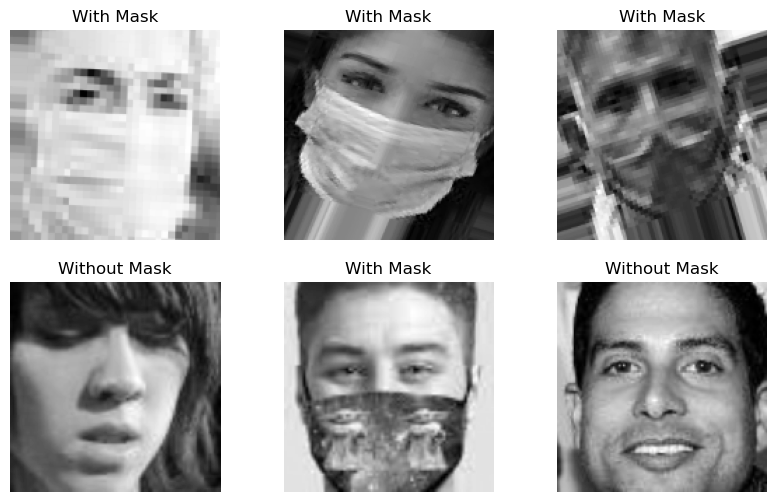

In [27]:
# shuffle된 train data 시각화
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

for row in range(2) :
    for col in range(3) :
        image_index = row * 100 + col

        ax[row, col].axis('off')
        ax[row, col].imshow(data[image_index][0], cmap='gray')

        if data[image_index][1] == 0 :
            ax[row, col].set_title("Without Mask")
        else :
            ax[row, col].set_title("With Mask")

## image data(x), label(y) 분류

In [30]:
x = []
y = []

for image in data :
    x.append(image[0])  # image pixel data
    y.append(image[1])  # label

x = np.array(x)
y = np.array(y)

## train data -> train, valid 분할

In [31]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=13)

## CNN 신경망 구성

In [35]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', input_shape=(150, 150, 1)),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(64, kernel_size=(5,5), strides=(2,2), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 38, 38, 64)        51264     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 19, 19, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 19, 19, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 23104)            

## 학습

In [37]:
x_train.shape, x_val.shape

((8000, 150, 150), (2000, 150, 150))

In [39]:
x_train = x_train.reshape(len(x_train), x_train.shape[1], x_train.shape[2], 1)
x_val = x_val.reshape(len(x_val), x_val.shape[1], x_val.shape[2], 1)

x_train.shape, x_val.shape

((8000, 150, 150, 1), (2000, 150, 150, 1))

In [40]:
hist = model.fit(x_train, y_train, epochs=4, batch_size=32)

Epoch 1/4
250/250 [==============================] - 116s 460ms/step - loss: 6.8773 - accuracy: 0.6388
Epoch 2/4
250/250 [==============================] - 105s 418ms/step - loss: 0.5913 - accuracy: 0.7423
Epoch 3/4
250/250 [==============================] - 114s 457ms/step - loss: 0.2074 - accuracy: 0.9206
Epoch 4/4
250/250 [==============================] - 122s 487ms/step - loss: 0.1398 - accuracy: 0.9488


## evaluate 후 metrics 확인

In [41]:
# evaluate (valid data)
model.evaluate(x_val, y_val)

63/63 [==============================] - 5s 77ms/step - loss: 0.1428 - accuracy: 0.9495


[0.14276061952114105, 0.9495000243186951]

In [42]:
# 0.5보다 큰 확률값은 class 1 (WithMask)
prediction = (model.predict(x_val) > 0.5).astype("int32")

print(classification_report(y_val, prediction))
print(confusion_matrix(y_val, prediction))

63/63 [==============================] - 5s 78ms/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1001
           1       0.94      0.96      0.95       999

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000

[[936  65]
 [ 36 963]]


## 모델의 예측이 틀린 데이터 확인

In [43]:
wrong_result = []

for n in range(0, len(y_val)) :
    if prediction[n] != y_val[n] :
        wrong_result.append(n)

len(wrong_result)

101

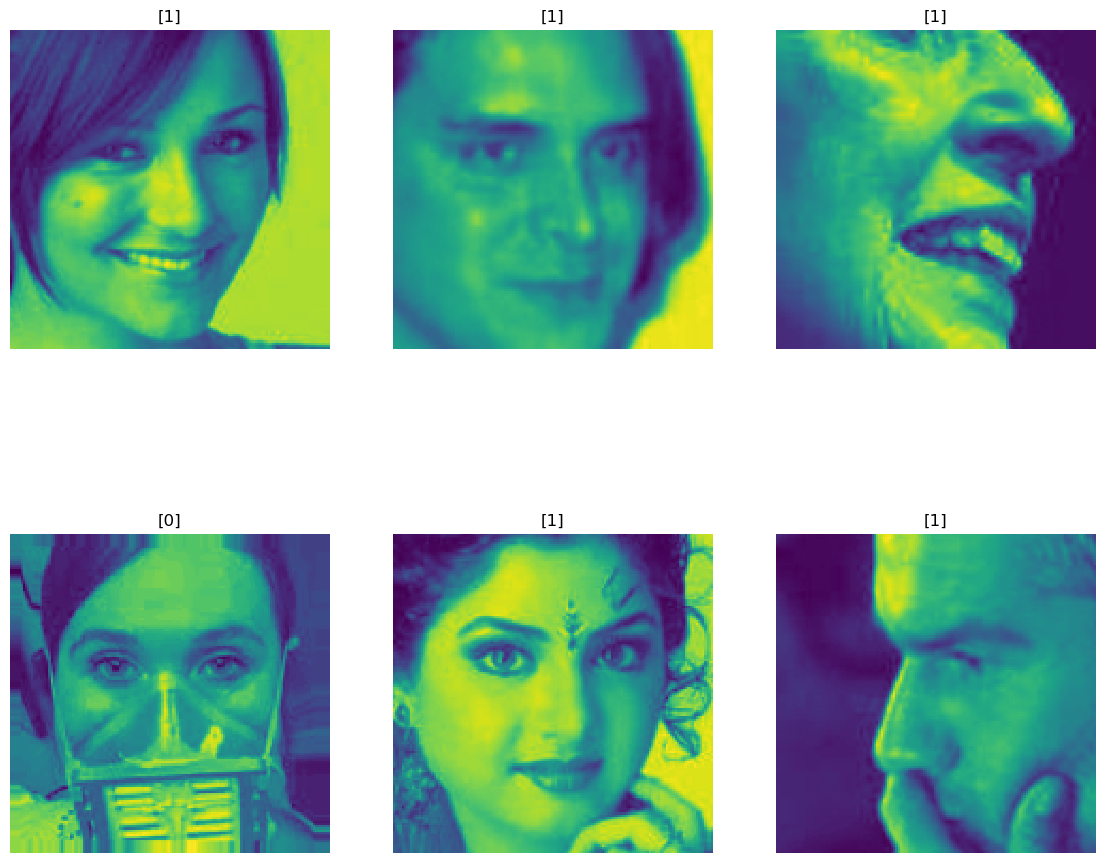

In [52]:
# 틀린 데이터 시각화
import random

samples = random.choices(population=wrong_result, k=6)

plt.figure(figsize=(14, 12))

for idx, n in enumerate(samples) :
    plt.subplot(2, 3, idx + 1)
    plt.imshow(x_val[n].reshape(150, 150), interpolation='nearest')
    plt.title(prediction[n])
    plt.axis('off')

plt.show()